# General tests of te AIS

Created on Tue Nov 22 16h24m,  2022

This is a script for the development of general tests

@author: denis


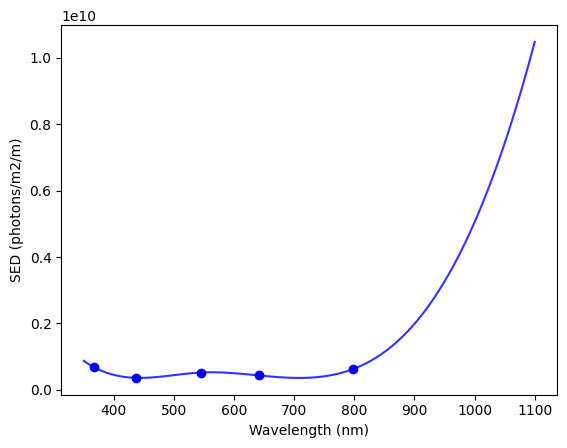

In [2]:
# Test sky SED
from AIS.Spectral_Energy_Distribution import Sky
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

ss = pd.read_csv("AIS/Spectral_Energy_Distribution/moon_magnitude.csv")
wv = np.linspace(350, 1100, 100)
sky = Sky()
sky_sed = sky.calculate_sed("new", wv)
plt.plot(wv, sky_sed[0], "b", alpha=0.8)
plt.plot(ss["wavelength"], sky._calculate_photons_density(ss["new"]), "ob")
plt.xlabel("Wavelength (nm)")
plt.ylabel("SED (photons/m2/m)")
plt.show()

# Plot the spectral response of the channel with each optical component in the light path

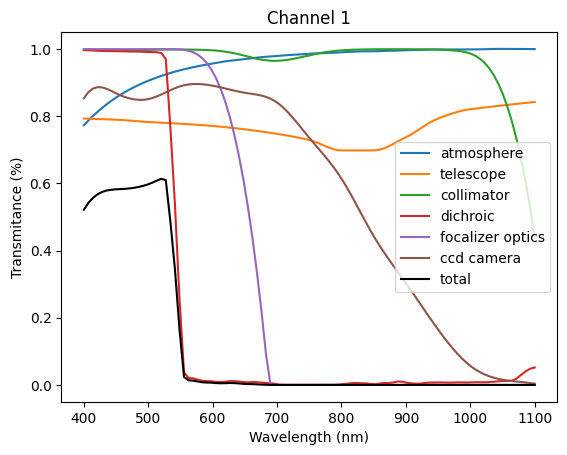

In [5]:
from AIS.Spectral_Response import Channel, Atmosphere, Telescope
import matplotlib.pyplot as plt
import numpy as np
import os

sr_total = np.ones(100)
wv = np.linspace(400, 1100, 100)

atm = Atmosphere()
sr = atm.get_spectral_response(wv, 1, "photometric")
sr_total *= sr
plt.plot(wv, sr, label="atmosphere")

tel = Telescope()
sr = tel.get_spectral_response(wv)
sr_total *= sr
plt.plot(wv, sr, label="telescope")

_channel_id = 1
channel = Channel(_channel_id)
sr = channel.get_spectral_response(wv, "collimator.csv")
sr_total *= sr
plt.plot(wv, sr, label="collimator")
sr = channel.get_spectral_response(wv, f"Channel {_channel_id}/dichroic.csv")
sr_total *= sr
plt.plot(wv, sr, label="dichroic")
sr = channel.get_spectral_response(wv, f"Channel {_channel_id}/camera.csv")
sr_total *= sr
plt.plot(wv, sr, label="focalizer optics")
sr = channel.get_spectral_response(wv, f"Channel {_channel_id}/ccd.csv")
sr_total *= sr
plt.plot(wv, sr, label="ccd camera")


plt.plot(wv, sr_total, "k", label="total")
plt.legend()  # loc='lower right')
# plt.ylim(0, 1.1)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmitance (%)")
plt.title(f"Channel {_channel_id}")
plt.savefig(os.path.join("notebook", "figures", f"Channel {_channel_id}.png"))
plt.show()

# Plot the spectral response of the SPARC4 and Sloan

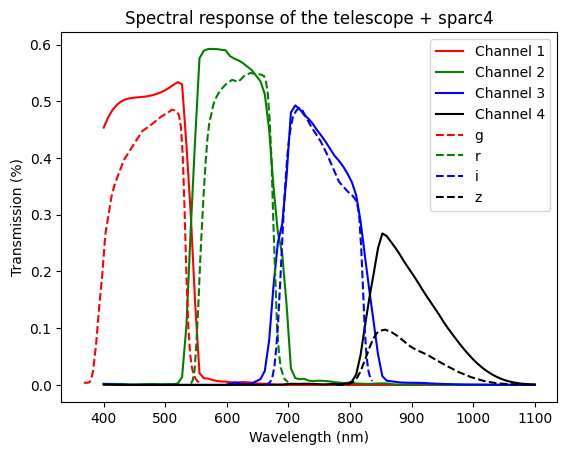

In [4]:
from AIS.Artificial_Image_Simulator import Artificial_Image_Simulator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# http://www.ioa.s.u-tokyo.ac.jp/~doi/sdss/SDSSresponse.html

sed = np.ones(100)
wv = np.linspace(400, 1100, 100)
colors = ["r", "g", "b", "k"]
ccd_operation_mode = {
    "em_mode": "Conv",
    "em_gain": 1,
    "preamp": 1,
    "readout": 1,
    "binn": 1,
    "t_exp": 1,
    "image_size": 100,
}
for i in [1, 2, 3, 4]:
    ais = Artificial_Image_Simulator(
        ccd_operation_mode, channel_id=i, ccd_temperature=-70
    )
    ais.write_source_sed(wv, sed)
    ais.create_sky_sed(moon_phase="new")
    ais.apply_atmosphere_spectral_response(sky_condition="regular")
    ais.apply_telescope_spectral_response()
    ais.apply_sparc4_spectral_response(acquisition_mode="photometry")
    plt.plot(wv, ais.source_sed, colors[i - 1], label=f"Channel {i}")

data = pd.read_csv("notebook/data_files/g_filter.csv")
plt.plot(data["Wavelength (angstroms)"] / 10, data["Transmission"], "r--", label="g")
data = pd.read_csv("notebook/data_files/r_filter.csv")
plt.plot(data["Wavelength (angstroms)"] / 10, data["Transmission"], "g--", label="r")
data = pd.read_csv("notebook/data_files/i_filter.csv")
plt.plot(data["Wavelength (angstroms)"] / 10, data["Transmission"], "b--", label="i")
data = pd.read_csv("notebook/data_files/z_filter.csv")
plt.plot(data["Wavelength (angstroms)"] / 10, data["Transmission"], "k--", label="z")


plt.legend()
plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmission (%)")
plt.title("Spectral response of the telescope + sparc4")
plt.savefig(os.path.join("notebook", "figures", "sparc4_photometry.png"), dpi=300)
plt.show()

# Plot spectral response of SPARC4 and SDSS with atm and telescope

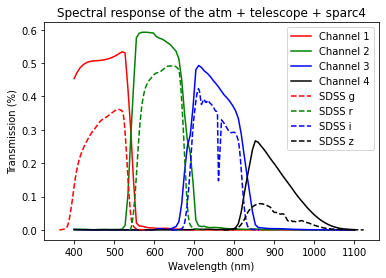

In [14]:
from AIS.Artificial_Image_Simulator import Artificial_Image_Simulator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# http://svo2.cab.inta-csic.es/svo/theory/fps3/index.php?id=SLOAN/SDSS.g&&mode=browse&gname=SLOAN&gname2=SDSS#filter

sed = np.ones(100)
wv = np.linspace(400, 1100, 100)
colors = ["r", "g", "b", "k"]
ccd_operation_mode = {
    "em_mode": "Conv",
    "em_gain": 1,
    "preamp": 1,
    "readout": 1,
    "binn": 1,
    "t_exp": 1,
    "image_size": 100,
}
for i in [1, 2, 3, 4]:
    ais = Artificial_Image_Simulator(
        ccd_operation_mode, channel_id=i, ccd_temperature=-70
    )
    ais.write_source_sed(wv, sed)
    ais.create_sky_sed(moon_phase="new")
    ais.apply_atmosphere_spectral_response(sky_condition="regular")
    ais.apply_telescope_spectral_response()
    ais.apply_sparc4_spectral_response(acquisition_mode="photometry")
    plt.plot(wv, ais.source_sed, colors[i - 1], label=f"Channel {i}")

base_path = os.path.join("notebook", "data_files", "SDSS_atm_tel")
for idx, filter in enumerate(["g", "r", "i", "z"]):
    file = os.path.join(base_path, f"SLOAN_SDSS.{filter}.dat")
    wv, resp = [], []
    with open(file) as arq:
        lines = arq.read().splitlines()
    for line in lines:
        tmp1, tmp2 = line.split(" ")
        wv.append(float(tmp1) / 10)
        resp.append(float(tmp2))
    plt.plot(wv, resp, f"{colors[idx]}--", label=f"SDSS {filter}")


plt.legend()
plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmission (%)")
plt.title("Spectral response of the atm + telescope + sparc4")
plt.savefig(os.path.join("notebook", "figures", "sparc4_photometry.png"), dpi=300)
plt.show()

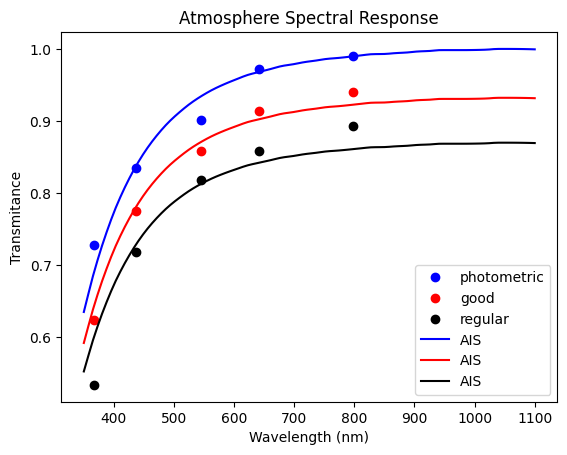

In [3]:
# Test the atmosphere spectral response
from AIS.Spectral_Response import Atmosphere
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

obj_wavelength = np.linspace(350, 1100, 100)
ss = pd.read_csv("AIS/Spectral_Response/willton.csv")
wv = ss["Wavelength (nm)"]
photometric = 10 ** (-0.4 * ss["photometric"])
good = 10 ** (-0.4 * ss["good"])
regular = 10 ** (-0.4 * ss["regular"])
plt.plot(wv, photometric, "bo", label="photometric")
plt.plot(wv, good, "ro", label="good")
plt.plot(wv, regular, "ko", label="regular")

atmosphere = Atmosphere()
spectral_response = atmosphere.get_spectral_response(obj_wavelength, 1)
plt.plot(obj_wavelength, spectral_response, "b", label="AIS")
spectral_response = atmosphere.get_spectral_response(obj_wavelength, 1, "good")
plt.plot(obj_wavelength, spectral_response, "r", label="AIS")
spectral_response = atmosphere.get_spectral_response(obj_wavelength, 1, "regular")
plt.plot(obj_wavelength, spectral_response, "k", label="AIS")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmitance")
plt.title("Atmosphere Spectral Response")
plt.legend()
plt.savefig("notebook/figures/atmosphere_spec_response.png")

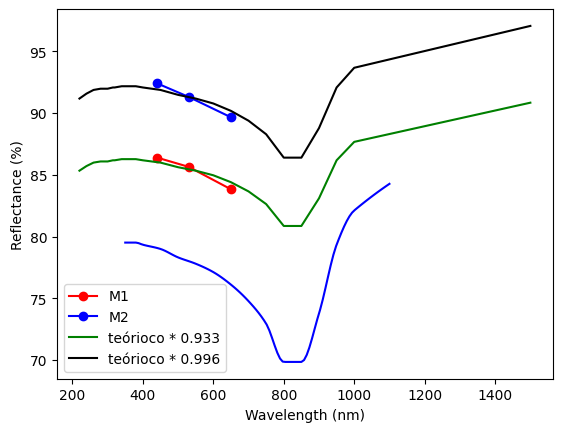

In [4]:
# Calc the ajust of the spectral response of the telescope

from AIS.Spectral_Response import Telescope
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import splrep, splev
from scipy.optimize import curve_fit
from sys import exit
import os


obj_wavelength = np.linspace(350, 1100, 100)
telescope = Telescope()
spectral_response = telescope.get_spectral_response(obj_wavelength) * 100
plt.plot(obj_wavelength, spectral_response, "b")

# ----------------------------------------------------------------------------------

wv = [440, 530, 650]
M1 = [86.392, 85.641, 83.825]
M2 = [92.40375, 91.3025, 89.65375]

ss = pd.read_csv("AIS/Spectral_Response/telescope.csv")


def func(x, c):
    ss = pd.read_csv("AIS/Spectral_Response/telescope.csv")
    spl = splrep(ss["Wavelength (nm)"], ss["Transmitance (%)"])
    spectral_response = splev(x, spl)
    return spectral_response * c


popt_M1, _ = curve_fit(func, wv, M1)
popt_M2, _ = curve_fit(func, wv, M2)

plt.plot(wv, M1, "o-r", label="M1")
plt.plot(wv, M2, "o-b", label="M2")
plt.plot(
    ss["Wavelength (nm)"],
    ss["Transmitance (%)"] * popt_M1[0],
    "g",
    label=f"teórioco * {popt_M1[0]:.3f}",
)
plt.plot(
    ss["Wavelength (nm)"],
    ss["Transmitance (%)"] * popt_M2[0],
    "k",
    label=f"teórioco * {popt_M2[0]:.3f}",
)
plt.legend()
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectance (%)")
plt.savefig(os.path.join("notebook", "figures", "adjust_aluminium_curve.png"))
plt.show()

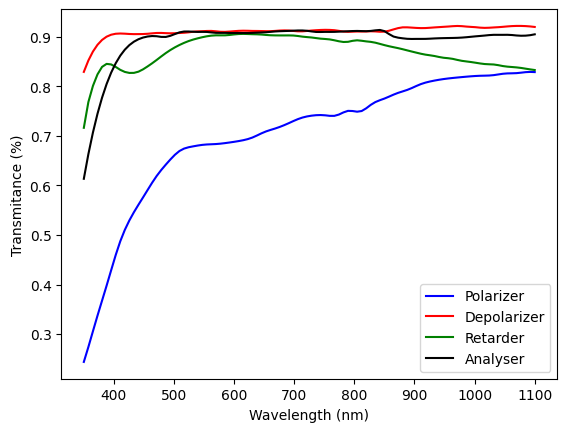

In [9]:
# Polarimetric spectral response curves

from AIS.Spectral_Response import Channel
import numpy as np
import matplotlib.pyplot as plt
import os

wv = np.linspace(350, 1100, 100)
channel = Channel(1)
spectral_response = channel.get_spectral_response(wv, "polarizer.csv")
plt.plot(wv, spectral_response, "b", label="Polarizer")

spectral_response = channel.get_spectral_response(wv, "depolarizer.csv")
plt.plot(wv, spectral_response, "r", label="Depolarizer")

spectral_response = channel.get_spectral_response(wv, "retarder.csv")
plt.plot(wv, spectral_response, "g", label="Retarder")

spectral_response = channel.get_spectral_response(wv, "analyzer.csv")
plt.plot(wv, spectral_response, "k", label="Analyser")

plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmitance (%)")
plt.legend()
plt.savefig(
    os.path.join("notebook", "figures", "polarimetric_spectral_response.png"), dpi=300
)
plt.show()

# Plot the spectral curve of a specific optical components

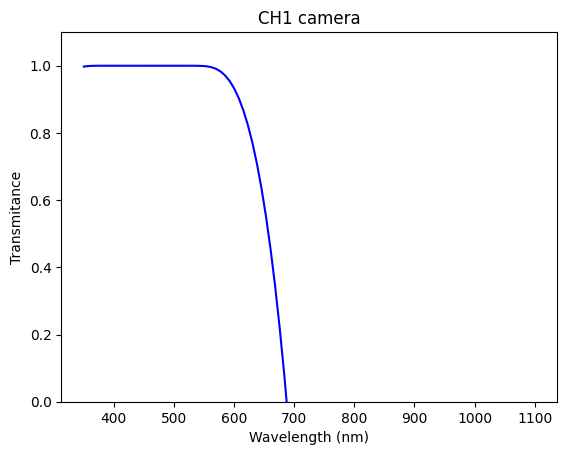

In [21]:
from AIS.Spectral_Response import Channel, Atmosphere, Telescope
import matplotlib.pyplot as plt
import numpy as np
import os


sr_total = np.ones(100)
wv = np.linspace(350, 1100, 100)
_channel_id = 1
optical_component = f"camera"
channel = Channel(_channel_id)
sr = channel.get_spectral_response(
    wv, f"Channel {_channel_id}\\{optical_component}.csv"
)
plt.plot(wv, sr, "b")
plt.ylim(0, 1.1)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmitance")
plt.title(f"CH{_channel_id} {optical_component}")
plt.savefig(
    os.path.join("notebook", "figures", f"CH{_channel_id} {optical_component}.png")
)
plt.show()

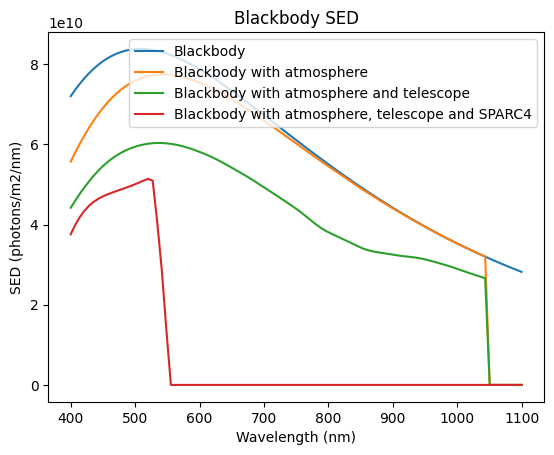

In [10]:
# Test the blackbody profile
from AIS.Artificial_Image_Simulator import Artificial_Image_Simulator
from AIS.Spectral_Energy_Distribution import Source
import matplotlib.pyplot as plt

ccd_operation_mode = {
    "em_mode": "Conv",
    "em_gain": 1,
    "preamp": 1,
    "readout": 1,
    "binn": 1,
    "t_exp": 1,
    "image_size": 100,
}

ais = Artificial_Image_Simulator(ccd_operation_mode, 1, -70)

ais.create_source_sed("blackbody", 15, (400, 1100, 100), 5700)
ais.create_sky_sed("new")
plt.plot(ais.wavelength, ais.source_sed[0], label="Blackbody")
ais.apply_atmosphere_spectral_response()
plt.plot(ais.wavelength, ais.source_sed[0], label="Blackbody with atmosphere")
ais.apply_telescope_spectral_response()
plt.plot(
    ais.wavelength, ais.source_sed[0], label="Blackbody with atmosphere and telescope"
)
ais.apply_sparc4_spectral_response("photometry")
plt.plot(
    ais.wavelength,
    ais.source_sed,
    label="Blackbody with atmosphere, telescope and SPARC4",
)
plt.legend()
plt.xlabel("Wavelength (nm)")
plt.ylabel("SED (photons/m2/nm)")
plt.title("Blackbody SED")
plt.show()

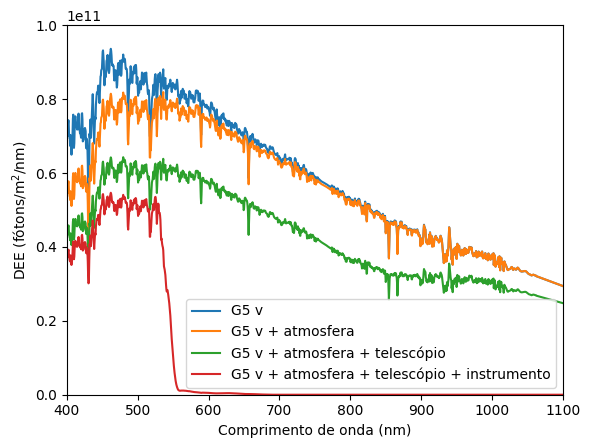

In [1]:
# Test the _read_spectral_library function
from AIS.Artificial_Image_Simulator import Artificial_Image_Simulator
import matplotlib.pyplot as plt

ccd_operation_mode = {
    "em_mode": "Conv",
    "em_gain": 1,
    "preamp": 1,
    "readout": 1,
    "binn": 1,
    "t_exp": 1,
    "image_size": 100,
}

ais = Artificial_Image_Simulator(ccd_operation_mode, 1, -70)

ais.create_source_sed("spectral_library", 15, (400, 1100, 100), spectral_type="g5v")
ais.create_sky_sed("new")
plt.plot(ais.wavelength, ais.source_sed[0], label="G5 v")
ais.apply_atmosphere_spectral_response()
plt.plot(ais.wavelength, ais.source_sed[0], label="G5 v + atmosfera")
ais.apply_telescope_spectral_response()
plt.plot(ais.wavelength, ais.source_sed[0], label="G5 v + atmosfera + telescópio")
ais.apply_sparc4_spectral_response("photometry")
plt.plot(
    ais.wavelength, ais.source_sed, label="G5 v + atmosfera + telescópio + instrumento"
)
plt.legend()
plt.xlabel("Comprimento de onda (nm)")
plt.ylabel(r"DEE (fótons/m$^2$/nm)")
plt.xlim(400, 1100)
plt.ylim(0, 1e11)
plt.savefig("notebook/figures/spectral_library.png", dpi=300)
plt.show()